## Contents  <a id='top'></a>

1. <a href=#intro>Introduction to APIs</a>
    1. HTTP requests
    2. HTTP responses
    3. Data Formats
    4. Authenticating with APIs
2. <a href="#with-req">Making HTTP requests with Python (Requests package)</a>
3. <a href="#flask">Creating an API in Python with the Flask package</a>
    1. Fitting a simple model with sklearn
    2. Running the API natively (without Docker)
4. <a href="#docker">Docker-izing your API</a>
    1. Building the image
    2. Using the API
5. <a href=#further>Further practice</a>
6. <a href="#ref">References</a>

## 1. Introduction to APIs <a id='intro'></a> 
<a href=#top>>back to top<</a>

Servers are programs that are continually running. They wait for a person or another program to request for something from it. An API is a tool that allows one computer (client) to communicate with a server.

### 1A. HTTP requests

HTTP (hypertext transfer protocol) is the main protocol on the internet. It is used for transferring websites and images. It is also the main protocol used when developing APIs.

Communication in HTTP revolves around requests and responses. The client sends a request, and the server sends a response. A valid request requires:

1. URL (Uniform resource locator)
    * A URL is a unique address for an object, known as a *resource*, on the server. 
    * When we browse web-pages, each of them has a unique address. When we work with an API, an object could be a *product*, or a *customer*.
2. Method
   * The four most common methods are:
       * GET: to ask the server to retrieve a resource
       * POST: to ask the server to create a new resource
       * PUT: to ask the server to edit/update an existing resource
       * DELETE: to ask the server to delete a resource.
3. List of headers
    * Headers provide meta-information about a request. Think of them as key-value pairs.
    * Suppose you direct your mobile phone browser to a web-page. That browser will send a GET request to the web-server to obtain the page. When it does so, it includes information in the "User-Agent" header that it is running on a mobile phone. The web-server can react to this and send a version of the page that is optimised for a mobile phone browser.
4. Body
    * Contains the data that the client wants to send to the server.
    * Here's what it looks like: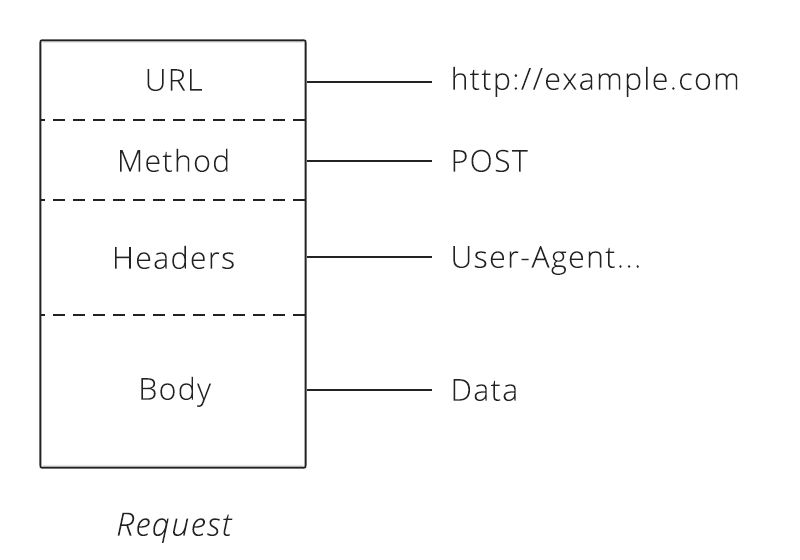

### 1B. HTTP responses

HTTP responses are very similar to requests, but instead of a method and a url, the response contains a status code. Responses are made up of

1. Status code
    * These are 3-digit numbers that have a unique meaning. Examples are 
        * 404: resource not found
        * 200: successful request.
        * 201: successfully created a resource on the server.
    * Here is a full list of [response codes](https://developer.mozilla.org/en-US/docs/Web/HTTP/Status).
2. Headers
3. Body

Here's an image of a response: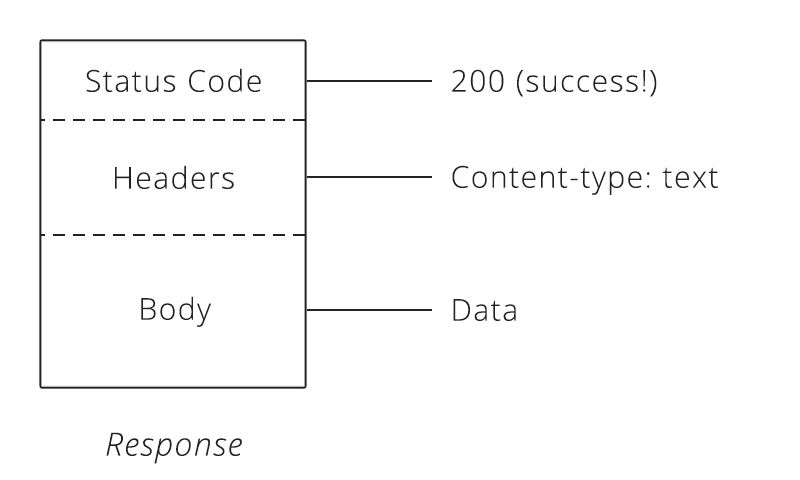


### 1C. Data Formats

APIs typically use either JSON or XML to format the data before sending it. The data format is specified in the *Content-Type* header field.

For instance, when the client sends a request with JSON data, it will include the value "application/json" in the Content-Type header field. The client can also specify the content that it expects/can work with. This is done in the *Accept* header field.

When the server responds, it will also include a specification of it's data format in the response header.

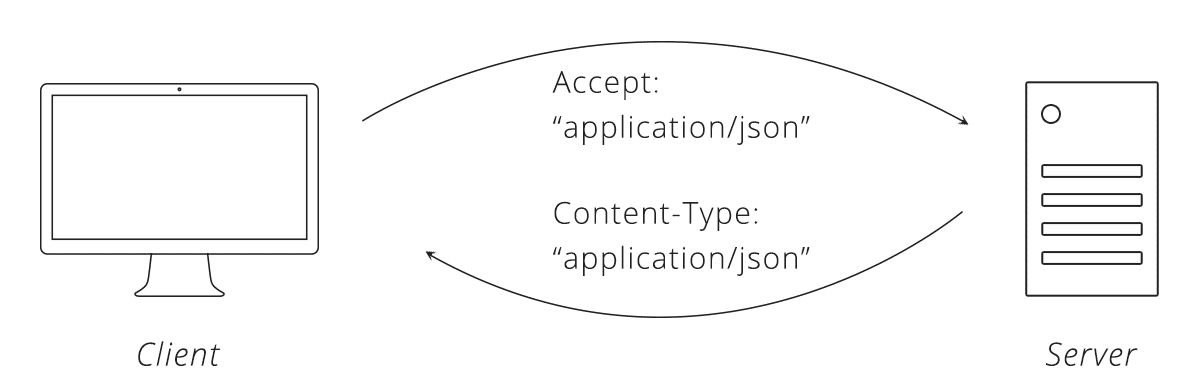

### 1D. Authenticating with APIs

Basic authentication simply combines a user name and password from the client into a hash and sends that to the server in the 'Authorization' field of the header.

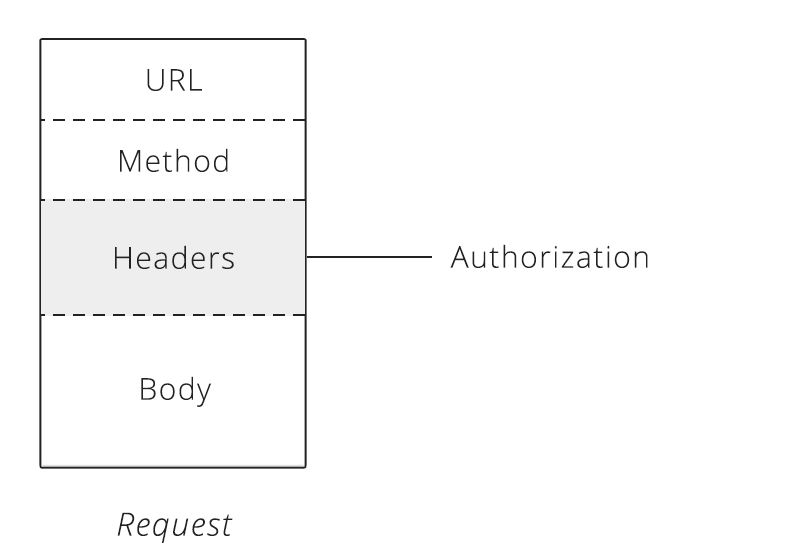

#### OAuth

Open Authentication is now very popular; the authentication is handed off to a server, which gives the client a temporary credential or token. The resource server uses this token to determine what resources and actions the client can perform on the resource server.

## 2. Making HTTP requests with Python <a id='with-req'></a> 
<a href=#top>>back to top<</a>
    
The most common calls we will make are GET calls. We shall practice with POST calls a little later. The reason we aren't working on it now is because, usually, POST calls in the wild require some sort of authentication. For now, we shall practice with an API call to some [data.gov](https://data.gov.sg/search?res_format=API) endpoints.

The first one involves obtaining the PSI readings at a particular time of day. The information about using this endpoint can be found on [this page](https://data.gov.sg/dataset/psi). The page informs us that the URL is 

> https://api.data.gov.sg/v1/environment/psi

There are two possible query parameters that could be included with the request: `date_time` and `date`.

If you have `curl` installed on your command line, you can use curl to quickly make http requests from the bash shell. However, in practice we will probably be writing code to communicate with an API, so let's focus on that approach.

The Python module `requests` is very widely used for making http requests.

In [ ]:
import requests
from datetime import datetime
%matplotlib inline

In [ ]:
psi_url = "https://api.data.gov.sg/v1/environment/psi"

Parameters should be placed in a python dictionary. 

In [ ]:
dt = datetime(2021, 2, 19, 18, 23)
dt_string = dt.strftime('%Y-%m-%dT%H:%M:00')
params1 = {'date_time': dt_string}

In [ ]:
req_out = requests.get(psi_url, params=params1)

All the information from the transaction is now stored in `req_out`. For instance, we can obtain:

* status code with `req_out.status_code`
* the final constructed URL with `req_out.url`
* the headers sent with `req_out.request.headers`
* the text content with  `req_out.text`
* if applicable, a dictionary containing the output with `req_out.json()`

In [ ]:
output = req_out.json()

This part almost always involves some checking/trial and error before we can proceed to write code to extract what we need. Here's the PM10 24hour reading from the north:

In [ ]:
output['items'][0]['readings']['pm10_twenty_four_hourly']['north']

Just in case you are curious, the equivalent `curl` call for this GET request would be:

`curl -X GET -d date_time="2021-02-19T18:23:00" https://api.data.gov.sg/v1/environment/psi`

* To modify headers in the request, we create a dictionary, and then supply the get method with a `headers` argument.
* To send data (not query parameters), we use the data or json arguments in the get method, e.g. `requests.get(psi_url, data=python_obj)`
* We shall demonstrate **uploading files** (with POST) and **downloading files** (with GET) once we have written our own API. 

*Try out the `date` query.*

## 3. Creating an API with Flask<a id='flask'></a> 
<a href=#top>>back to top<</a>

There are two common architectures for APIs: 
* SOAP, XML-based and very structured.
* REST, very open, allows for too much customisation.

When you design your API, the following steps may help:

1. What resources should be available to clients?
2. Assign URLs (or endpoints) to those resources.
3. What actions should the client be able to perform on those resources?
4. What pieces of data are required for ech action, and what format should they be in?

When assigning URLS to resources, a typical convention is to a hierarchical naming starting with the plural of the resource name, e.g.
`/orders`. Specific instances of the resouce will have an endpoint of the form `/orders/<order_id>`.
    

Here's what we are going to do next:

1. Fit a linear regression model to the HDB data from our server.
    * response variable: price per square meters, 
    * explanatory variables: town and storey
2. Save the model to a file.
3. Create a Flask application that has 5 endpoints:
    1. given a new X-row, generate and return a single prediction.
    2. given multiple X-rows, generate and return multiple predictions.
    3. return a plot of price-per-square-meters vs. storey.
    4. upload a "model" file, for future use.
    5. list all "models" on the server.

### 3A. Fitting the model using sklearn

In [ ]:
import requests
import pandas as pd
import numpy as np

First, we read in and select the columns we wish to work with:

In [ ]:
all_data = pd.read_csv("../data/resale-flat-prices-based-on-registration-date-from-jan-2017-onwards.csv")

In [ ]:
hdb4 = all_data.loc[(all_data.flat_type == "4 ROOM") & (all_data.month.str.contains('2019')), 
                    ['town', 'storey_range', 'floor_area_sqm', 'resale_price']]

storey_columns = hdb4.storey_range.str.split(pat=" TO ", expand=True)
storey_columns.columns = ['storey_min', 'storey_max']

hdb4['storey'] = storey_columns.apply(lambda x: (int(x.iloc[0])+int(x.iloc[1]))/2, axis=1)

hdb4['ppsqm'] = hdb4.resale_price/hdb4.floor_area_sqm

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

In [ ]:
lm1 = LinearRegression()
ct1 = ColumnTransformer([('categories', OneHotEncoder(dtype='int'), ['town'])], remainder='passthrough')

X = hdb4.loc[:, ['town', 'storey']]
ct1.fit(X)

X_new = ct1.transform(X)
lm1.fit(X_new, hdb4.ppsqm)

In [ ]:
import joblib

joblib.dump((lm1, ct1, hdb4), 'lm_api.pkl', compress=3)

In [ ]:
del lm1, ct1, hdb4

### 3B. Overview of the Flask application

The flask application is in the `lm1/` folder. The python file contains all the endpoints, and curl commands for you to test them on. Notice the `templates` folder. It contains the jinja templates the the flask application will use to render return pages.

````
+-- lm1/
|   +-- Dockerfile
|   +-- README.md
|   +-- lm1.py
|   +-- fit_model.py
|   +-- resale-flat-prices...csv
|   +-- requirements.txt
|   +-- templates/
|   +-- test2.png
````

To run the application natively (not as a Docker container), perform the following steps:

1. Copy the csv file into lm1/
2. Change directory to lm1/ and run `fit_model.py`.
3. `flask --app lm1 run`

If you point your browser to <http:127.0.0.1:5000/plot> you should see a plot.

## 4. Docker-ising your API <a id='docker'></a> 
<a href=#top>>back to top<</a>

### 4B. Building the image
    
To share your application as a Docker container, first we build the image on our machine with:
    
`docker build -t lm1 .`
    
Next, we run the image as a container:
    
`docker run --name lm1-01 -p9001:5000 -d lm1`

### 4A. Using our API

#### A. Given a new X-row, generate and return a single prediction

GET request to endpoint `http:127.0.0.1:9001/prediction` for single prediction:

In [ ]:
url1 = 'http://127.0.0.1:5000/prediction'
param1 = {'town': 'CLEMENTI', 'storey':13}
r1 = requests.get(url1, params=param1)
r1.json()

In [ ]:
r1.url

#### B. Given multiple X-rows, generate and return multiple predictions

GET request to endpoint `http:127.0.0.1:9001/prediction` for multiple predictions:

In [ ]:
url2 = 'http://127.0.0.1:5000/predictions'
h1 = {'Content-type': 'application/json', 'Accept': 'application/json'}
data1 = {'town': ['CLEMENTI', 'MARINE PARADE', 'GEYLANG'], 'storey':[13, 3, 5]}

r2 = requests.get(url2, headers=h1, json=data1)
#r2 = requests.get(url2, json=data1)

In [ ]:
r2.text

#### C. Return a (pre-generated) plot

GET request to endpoint `http:127.0.0.1:9001/plot` for plot:

In [ ]:
url3 = 'http://127.0.0.1:5000/plot'
r3 = requests.get(url3) # if it's a big file, use stream=True and then use r3.iter_content

with open('new_image.png', 'wb') as f:
    f.write(r3.content)

r3.close()

#### D. Upload a file to the server (POST)

POST request to endpoint `http://127.0.0.1:9001/upload` for model upload:

In [ ]:
url4 = 'http://127.0.0.1:5000/upload'

In [ ]:
pwd

In [ ]:
with open('X.log', 'rb') as f:
    files = {'model': ('test_upload.txt', f)}
    r4 = requests.post(url4, files=files)

In [ ]:
r4.text

#### E. List all models on the server

To list models, go to http://localhost:5000/list_models 

## Further Practice <a id='further'></a>
<a href=#top>>back to top<</a>

1. Modify the lm1 Docker container to train the model within the container. That way we don't have to copy a pkl file over.
2. Modify the lm1 API to return a plot of ppsqm vs. storey, for a specified town. It may not be prudent to write to a file first!
3. Read up on the [github API](https://docs.github.com/en/rest) and use it to extract all the contributors to .gitignore on main branch of dsa3101-2210.
4. Read up on the [Canvas API](https://canvas.instructure.com/doc/api/) and use it to upload a file to your folder in the DSA3101 course.
5. The [plumber package in R](https://www.rplumber.io/) allows you to create APIs with R, similar to Flask. Take a look at the documentation, then experiment with the docker image provided in the `r_api/` folder.
6. Use the `httr` package in R to recreate the API requests in this workbook.
    

## References <a id='ref'></a> 
<a href=#top>>back to top<</a>

1. [Introduction to APIs with Zapier](https://zapier.com/learn/apis/)
2. [Python requests module quickstart](https://requests.readthedocs.io/en/latest/user/quickstart/)
3. [Python Flask module quickstart](https://flask.palletsprojects.com/en/2.2.x/quickstart/)